## Single-component Bose-Hubbard model: Ground state properties

In [1]:
using QuantumOptics
using Plots
using Arpack
using ArnoldiMethod
using DelimitedFiles
using LaTeXStrings
using LinearAlgebra
using Statistics
pyplot()

Plots.PyPlotBackend()

### Set up the basis
We start by setting up the basis. We have `Nparticles` living on `Nsites`, and we use the QuantumOptics function `NLevelBasis()` to account for our sites. Each site is one level, which can be occupied by as many particles as we want (since we're dealing with bosons). For the basis size this is a little troublesome, since it leads to a large number of basis states. 

In [2]:
Nsites = 6                             # Actual number of physical sites is half this, we encode particle types at different sites
Nparticles = 6                      # To define the rotated state we initially need double the number of particles
a = NLevelBasis(Nsites)
a_mb = ManyBodyBasis(a, bosonstates(a, Nparticles))

ManyBody(onebodybasis=NLevel(N=6), states:462)

The many-body basis is spanned by the different occupations on every site. We can inspect the occupation numbers:

In [3]:
Dim=size(a_mb.occupations)[1] # Dimension of the Hilbert Space

462

### Set up the Hamiltonian

The Hamiltonian contains two terms, a tunneling term, and an on-site interaction term, respectively. If we express all energies in units of the tunneling rate $t$ the only free parameter is the on-site interaction $U$:
$$
    \mathcal{H} = -\sum_{\langle i,j \rangle} \hat{a}^\dagger_i \hat{a}_j + \frac{U}{2} \sum_i \hat{n}_i \left( \hat{n}_i - 1 \right)
$$

This Hamiltonian equation is actually the same as

$$
    \mathcal{H} = \sum_{j=1}^N J_x\left(\sigma_j^x \sigma_{j+1}^x+\sigma_j^y \sigma_{j+1}^y\right)+J_z \sigma_j^z \sigma_{j+1}^z
$$

In [91]:
single_tunnel = [transition(a, i, i + 1) for i in 1 : (Nsites - 1)]
#single_tunnel = vcat(single_tunnel, transition(a,Nsites,1))
single_tunnel = [dagger.(single_tunnel); single_tunnel]
total_tunnel_s = sum([manybodyoperator(a_mb, t) for t in single_tunnel]);
onsite_interaction = sum( [ number(a_mb, i) * (number(a_mb, i) - identityoperator(a_mb)) for i in 1:Nsites ] );

Define the Hamiltonian with all energies in units of $t$, the tunneling matrix element.

In [93]:
H(U) = -total_tunnel_s + U/2 * onsite_interaction

Htemp = -total_tunnel_s + 2/2 * onsite_interaction

Operator(dim=462x462)
  basis: ManyBody(onebodybasis=NLevel(N=6), states:462)sparse([1, 2, 1, 2, 3, 7, 2, 3, 4, 8  …  454, 459, 460, 461, 455, 460, 461, 462, 461, 462], [1, 1, 2, 2, 2, 2, 3, 3, 3, 3  …  460, 460, 460, 460, 461, 461, 461, 461, 462, 462], ComplexF64[30.0 + 0.0im, -2.449489742783178 + 0.0im, -2.449489742783178 + 0.0im, 20.0 + 0.0im, -1.0 + 0.0im, -3.1622776601683795 + 0.0im, -1.0 + 0.0im, 20.0 + 0.0im, -1.0 + 0.0im, -2.23606797749979 + 0.0im  …  -1.4142135623730951 + 0.0im, -3.4641016151377544 + 0.0im, 14.0 + 0.0im, -3.1622776601683795 + 0.0im, -1.0 + 0.0im, -3.1622776601683795 + 0.0im, 20.0 + 0.0im, -2.449489742783178 + 0.0im, -2.449489742783178 + 0.0im, 30.0 + 0.0im], 462, 462)

### Time evolution

In [96]:
Energy_Spectrum=eigenstates(dense(H(0.5)))[1]
E_Spacing = [Energy_Spectrum[i]-Energy_Spectrum[i-1] for i in 2 : (Dim)]
filter!(x->x>1e-10,E_Spacing)

600-element Vector{Float64}:
 2.090068820036171
 1.8054663164326215
 0.2151757358135047
 0.41188118394279094
 1.1230995764692029
 0.21216099597112503
 0.5658381200732521
 0.2541752464443263
 0.6093561590739096
 0.27017322415719747
 0.0009088414925617627
 0.45033406949639865
 0.012454746437088104
 ⋮
 0.14115593185923814
 0.2583180252434829
 0.026796948635844586
 0.8473373936620874
 0.16451704575844417
 0.2824383997487132
 0.11925408332388443
 0.25276716704781776
 0.17852284887369763
 2.2875453491874076
 0.01684797219826706
 0.010089434312156698

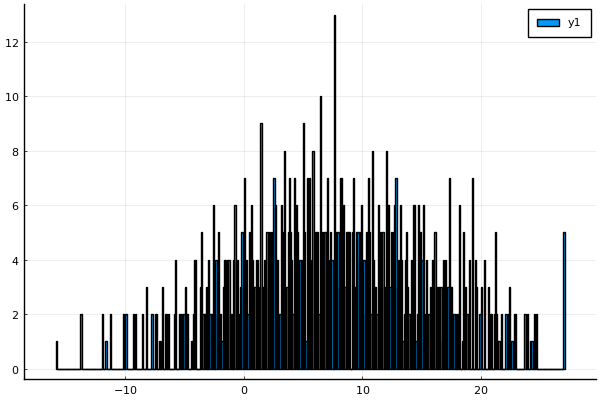

In [107]:
histogram(Energy_Spectrum,bins=500)

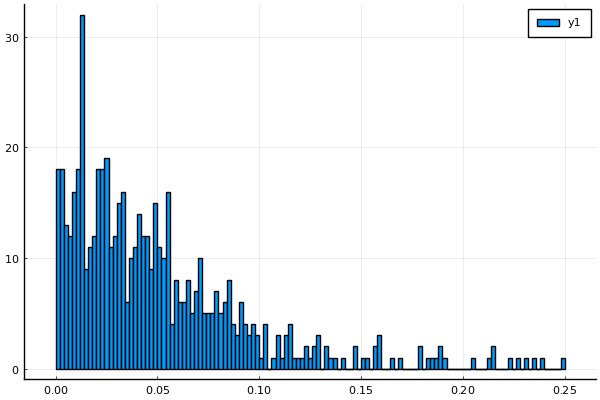

In [105]:
histogram(E_Spacing,bins=0:0.002:0.25)

One hallmark of the Mott-insulating state is that the number fluctuations disappear as we increase the lattice depth. We can calculate these by evaluating the expectation values for the operators $\hat{n_i}$ and $\hat{n_i}^2$, and averaging them over all sites.

In [45]:
Δn(ψ) = sqrt.( mean(real.( [expect(number(a_mb, i)^2, ψ) - expect(number(a_mb, i), ψ)^2 for i in 1:Nsites ] )) )

Δn (generic function with 1 method)

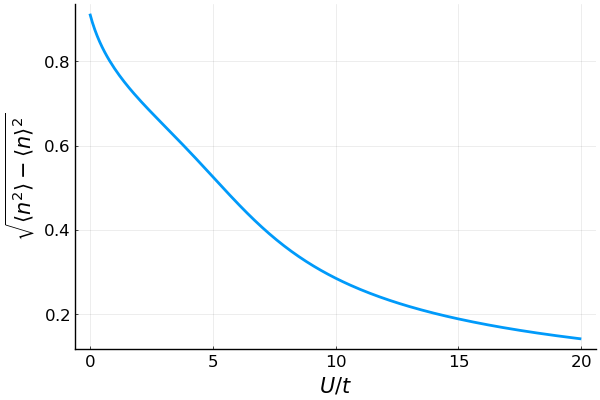

In [46]:
us = 0:0.1:20
dat = [Δn( getGS(u) ) for u in us];

plot(us, dat,
    label = "test",
    linewidth = 2,
    xlabel = L"U/t",
    ylabel = L"\sqrt{\langle n^2 \rangle - \langle n \rangle^2}",
    xguidefont = font(15),
    yguidefont = font(15),
    tickfont = font(12),
    leg = false)

We can also look at the behavior on every site individually:

In [47]:
Δn_ps(ψ) = [sqrt.( real( expect(number(a_mb, i)^2, ψ) - expect(number(a_mb, i), ψ)^2 ) ) for i in 1:Nsites ]

Δn_ps (generic function with 1 method)

In [48]:
us = 0:0.1:20
dat = [Δn_ps( getGS(u) ) for u in us];

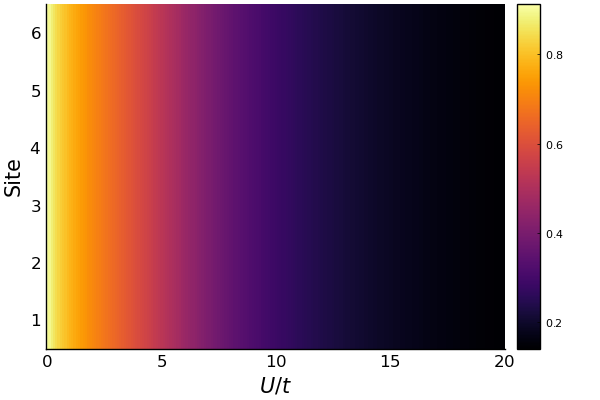

In [49]:
heatmap(us, 1:Nsites, hcat(dat...),
    xlabel = L"U/t",
    ylabel = "Site",
    xguidefont = font(15),
    yguidefont = font(15),
    tickfont = font(12))

In [54]:
tspan = [0:0.01:1;]


101-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 0.89
 0.9
 0.91
 0.92
 0.93
 0.94
 0.95
 0.96
 0.97
 0.98
 0.99
 1.0